## Strategy

> To trade the VIX 

### *Signals*

> Touch of lower bound = close sell and build long position

> Cross of upper std dev multiple = sell entire position


In [12]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime

In [395]:
# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df.head()

# identifying the VIX
vix = df['Series 28'].iloc[1200:1550]

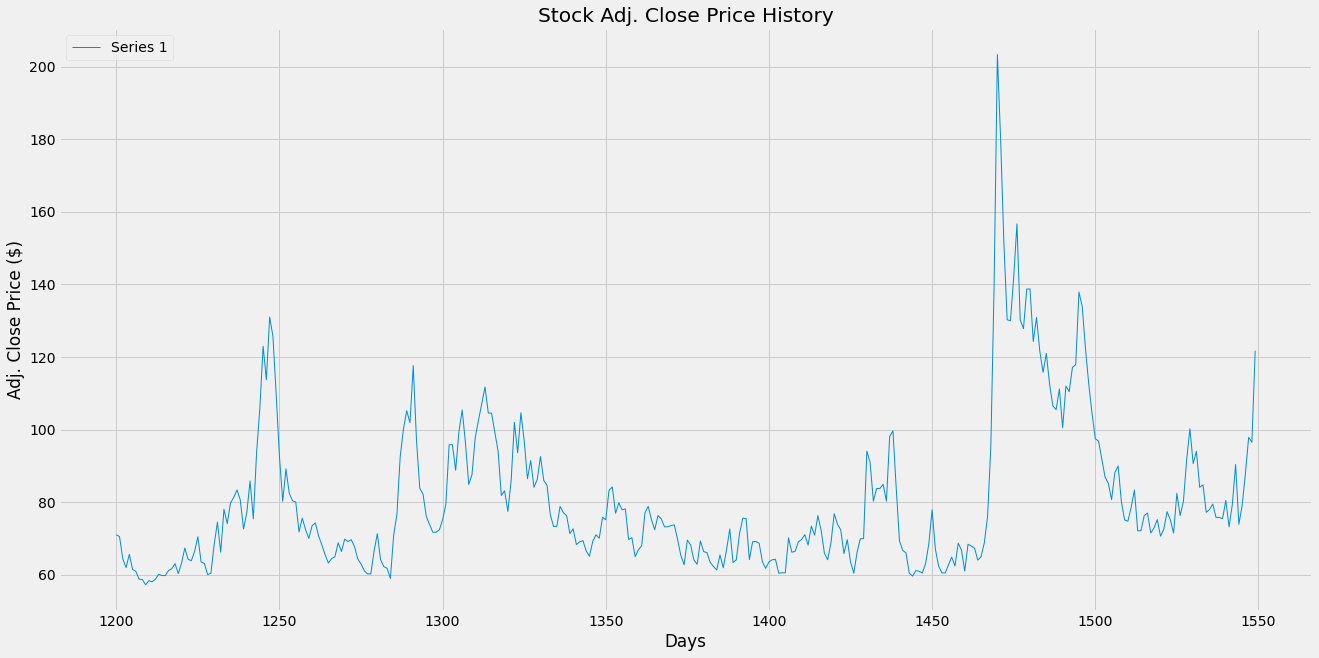

In [396]:
#Visualise the data
plt.figure(figsize=(20, 10))
plt.plot(vix, linewidth = 1)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()

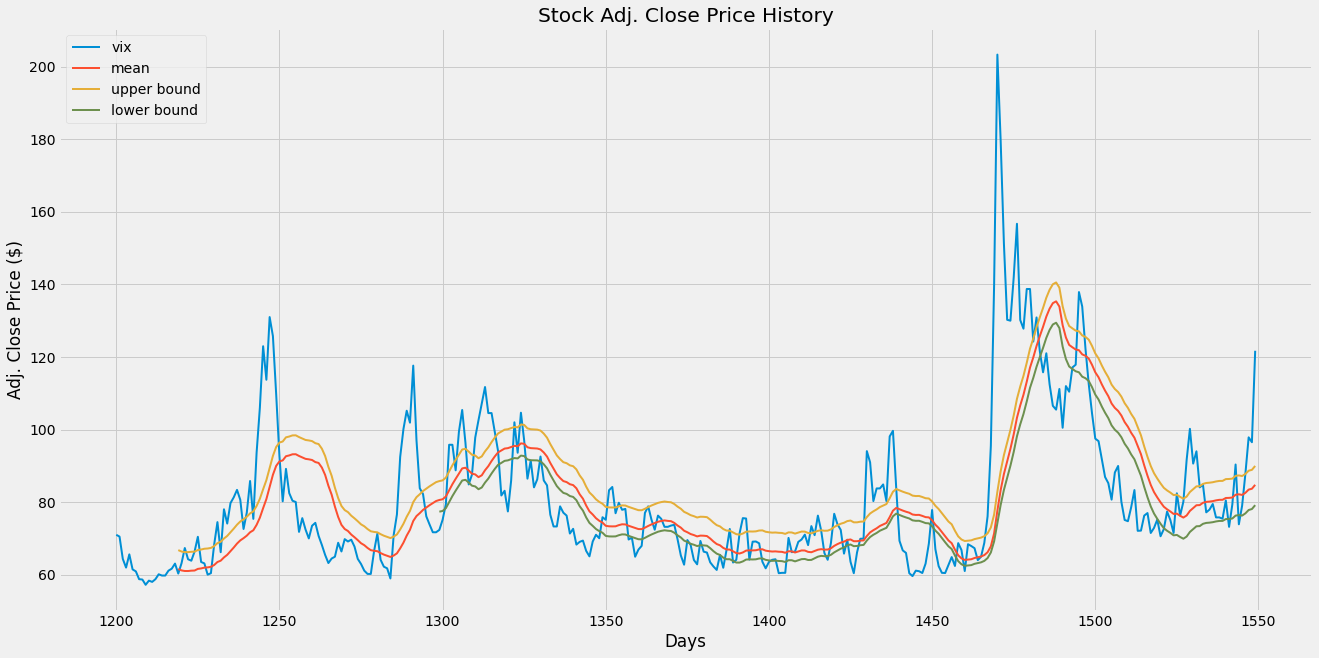

In [397]:
#Visualise the moving average and upper and lower bounds

# inputs
window_mean = 20
window_std = 100
upper_bound = 0.25   # number of stdv from mean
lower_bound = 0.2     # number of stdv below mean

# plotting
plt.figure(figsize=(20, 10))
plt.plot(vix, linewidth=2, label='vix')
plt.plot(vix.rolling(window=window_mean).mean(), linewidth=2, label='mean')
plt.plot(vix.rolling(window=window_mean).mean() + upper_bound*vix.std()\
         , linewidth=2, label='upper bound')
plt.plot(vix.rolling(window=window_mean).mean() - lower_bound*vix.rolling(window=window_std).std()\
         , linewidth=2, label='lower bound')
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(loc='upper left')
plt.show()

In [413]:
# vix strategy

def vixen(data, window_mean, upper_bound, lower_bound, trade_size_sell, trade_size_buy): 
    # generating simple moving average
    
    # constraints
    max_cap = 500000
    position = 0
    
    # data - is the series to generate signals for
    # window - is the window used to generate the average
    # lag - is how far % past the average before a signal is generated
    SMA = data.rolling(window = window_mean).mean()
    upper_bounds = SMA + upper_bound*vix.std()
    lower_bounds = SMA - lower_bound*vix.std()
    
    # generating signals
    sigPriceBuy = []
    sigPriceSell = []
    run_pos = []
    trade = []
      
    #flag = 1: long position, flag = 0: short position, flag = -1: no position
    flag = 0

    for i in range(len(data)):
        # closing trade at end of session
        trades_to_close = position/trade_size_sell
        
        if i == int((len(data)-(trades_to_close))):
            if position > 0:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(data.iloc[i])
                run_pos.append(position)
                position -= trade_size_sell
                trade.append(-trade_size_sell)
        # Touch of lower bound = close sell and build long position until max trade reached
        elif (data.iloc[i]<lower_bounds.iloc[i]) and (position<max_cap):
            sigPriceBuy.append(data.iloc[i])
            sigPriceSell.append(np.nan)
            run_pos.append(position)
            position += trade_size_buy
            trade.append(trade_size_buy)
            
        elif (data.iloc[i]>upper_bounds.iloc[i]) and (position>0) and (data.iloc[i]-data.iloc[i-1]>0):
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(data.iloc[i])
            run_pos.append(position)
            if position > trade_size_sell:
                position -= trade_size_sell
                trade.append(-trade_size_sell)
            else:
                position -= trade_size_buy
                trade.append(-trade_size_buy)

        else: 
            run_pos.append(position)
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
            trade.append(np.nan)

    return (sigPriceBuy, sigPriceSell, run_pos, trade)

buy_sell_data = vixen(vix, window_mean, upper_bound, lower_bound, 100000, 50000)

trades.head(25)

,Price,Running Position,Trades,Profit,Cumulative Profit
Day,,,,,
0,100.000000,0,NaN,NaN,NaN
1,96.556886,0,NaN,-0.000000e+00,0.000000e+00
2,95.608782,0,NaN,-0.000000e+00,0.000000e+00
3,95.109780,0,NaN,-0.000000e+00,0.000000e+00
4,90.469062,0,NaN,-0.000000e+00,0.000000e+00
5,87.574850,0,NaN,-0.000000e+00,0.000000e+00
6,91.067864,0,NaN,0.000000e+00,0.000000e+00
7,89.071856,0,NaN,-0.000000e+00,0.000000e+00
8,87.974052,0,NaN,-0.000000e+00,0.000000e+00


## Strategy Tester Cell

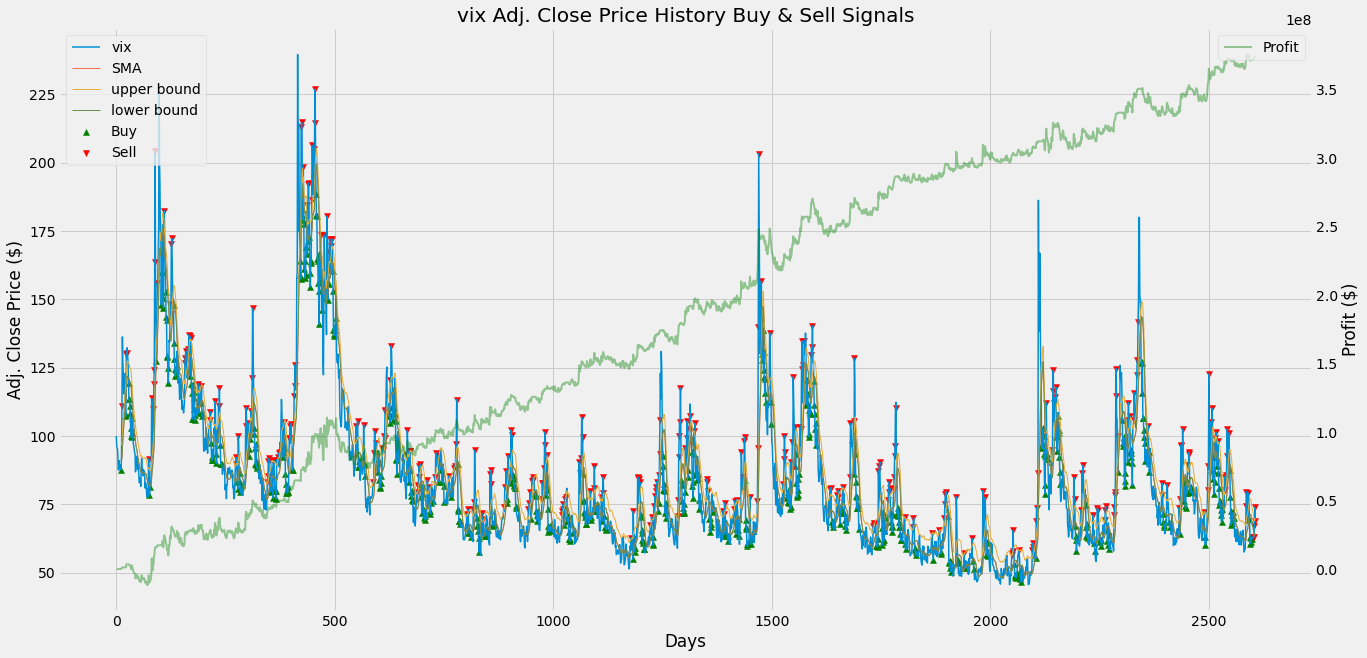

In [414]:
# testing basic strategy
# To test, change window and the series used

# =========================================
# variables
window_mean = 12
upper_bound = 0.2   # number of stdv from mean
lower_bound = 0.0    # number of stdv below mean
trade_size_sell = 100000    # daily trade increment
trade_size_buy = 50000    # daily trade increment
# =========================================

#Store the buy and sell data into a variable
buy_sell_data = vixen(vix, window_mean, upper_bound, lower_bound, trade_size_sell, trade_size_buy)

# format outputs
trades = pd.DataFrame(vix.index)
trades['Price'] = vix.values
trades['Running Position'] = buy_sell_data[2]
trades['Trades'] = buy_sell_data[3]
trades['Profit'] = (trades['Price'][1::]-trades['Price'].shift(1)[0:-1]) * trades['Running Position']
trades['Cumulative Profit'] = trades['Profit'].cumsum()
trades = trades.set_index('Day')

# visualise test
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

# adding price data
ax1.plot(vix, label='vix', alpha=1, linewidth=1.5)
ax1.plot(vix.rolling(window=window_mean).mean(), label='SMA', alpha=0.8, linewidth=1)
ax1.plot(vix.rolling(window=window_mean).mean() + upper_bound*vix.std()\
         , linewidth=1, label='upper bound')
ax1.plot(vix.rolling(window=window_mean).mean() - lower_bound*vix.std()\
         , linewidth=1, label='lower bound')
# plot profit
ax2.plot(trades.index, trades['Cumulative Profit'], linewidth=2, color='green', label='Profit', alpha=.4)
# adding indicators
ax1.scatter(vix.index, buy_sell_data[0], label='Buy', marker='^', color='green')
ax1.scatter(vix.index, buy_sell_data[1], label='Sell', marker='v', color='red')
ax1.set_title('vix Adj. Close Price History Buy & Sell Signals')
ax1.set_xlabel('Days')
ax1.set_ylabel('Adj. Close Price ($)')
ax2.set_ylabel('Profit ($)')
ax2.grid(False)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

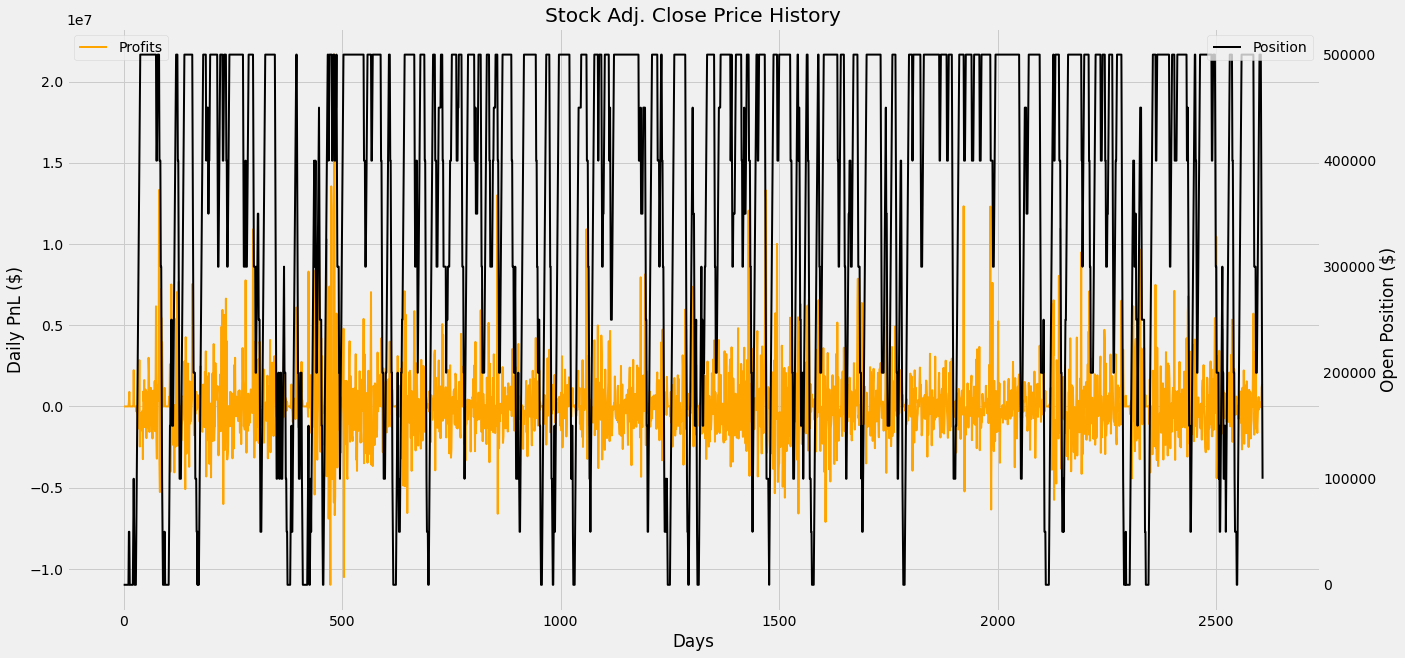

In [415]:
# Plotting Returns
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

ax1.plot(trades.index, trades['Profit'], linewidth=2, label='Profits', color='orange')
ax2.plot(trades.index, trades['Running Position'], linewidth=2, label='Position', color='black')
ax1.set_title('Stock Adj. Close Price History')
ax1.set_xlabel('Days')
ax2.set_ylabel('Open Position ($)')
ax1.set_ylabel('Daily PnL ($)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.grid(False)
plt.show()

In [401]:
#Calculating returns

def Backtest(data, trades):
    
    profit = np.nansum(trades['Profit'])
    
    return profit

Backtest(vix, trades)

82934630.73852296

In [402]:
# optimising parameters

def Optimiser(data, trade_size):
    
    # trade_size - increment of trades
    max = [0]
    
    for wm in np.linspace(2,200,20):
            for ub in np.linspace(0,1,6):
                for lb in np.linspace(0,1,6):
                    for tss in np.linspace(100000,100000,1):
                        for tsb in np.linspace(70000,70000,1):
                    
                            buy_sell_data = vixen(vix, int(wm), ub, lb, tss, tsb)
                            trades = pd.DataFrame(vix.index)
                            trades['Price'] = vix.values
                            trades['Running Position'] = buy_sell_data[2]
                            trades['Trades'] = buy_sell_data[3]
                            trades['Profit'] = (trades['Price'][1::]-trades['Price'].shift(1)[0:-1]) * trades['Running Position']
                            trades['Cumulative Profit'] = trades['Profit'].cumsum()
                            trades = trades.set_index('Day')

                            # profit for tested parameters
                            profit = Backtest(data, trades)

                            #print(profit, tss, tsb)

                            if profit > max[0]:
                                max = [profit, wm, ub, lb, tss, tsb]
                    
    return max
    
for i in np.arange(1):
    vix = df['Series 28']
    print(Optimiser(vix, 100000))

[413259481.0379242, 12.421052631578947, 0.2, 0.0, 100000.0, 70000.0]
